In [1]:
!git clone https://github.com/dhrim/darkeras-yolov4

Cloning into 'darkeras-yolov4'...
remote: Enumerating objects: 129, done.
remote: Counting objects: 100% (129/129), done.
remote: Compressing objects: 100% (121/121), done.
remote: Total 129 (delta 57), reused 10 (delta 3), pack-reused 0
Receiving objects: 100% (129/129), 5.57 MiB | 11.61 MiB/s, done.
Resolving deltas: 100% (57/57), done.


In [2]:
%cd darkeras-yolov4

/content/darkeras-yolov4


# 모델 파일 다운로드

In [3]:
!wget -O weights/yolov3.weights https://pjreddie.com/media/files/yolov3.weights

--2022-01-05 06:46:34--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘weights/yolov3.weights’

weights/yolov3.weig 100%[===================>] 236.52M  40.3MB/s    in 6.2s    

2022-01-05 06:46:41 (37.9 MB/s) - ‘weights/yolov3.weights’ saved [248007048/248007048]



In [4]:
!wget -O weights/yolov3-tiny.weights https://pjreddie.com/media/files/yolov3-tiny.weights


--2022-01-05 06:46:41--  https://pjreddie.com/media/files/yolov3-tiny.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35434956 (34M) [application/octet-stream]
Saving to: ‘weights/yolov3-tiny.weights’

weights/yolov3-tiny 100%[===================>]  33.79M  27.3MB/s    in 1.2s    

2022-01-05 06:46:42 (27.3 MB/s) - ‘weights/yolov3-tiny.weights’ saved [35434956/35434956]



copy from https://github.com/tranleanh/darkeras-yolov4/blob/main/darkeras-yolov3.ipynb

# 모델 생성

In [5]:
import yolov3_wrapper

In [6]:
model = yolov3_wrapper.YoloV3Wrapper("./weights/yolov3.weights")

In [7]:
model.save("yolov3.h5")

# 이미지 로딩

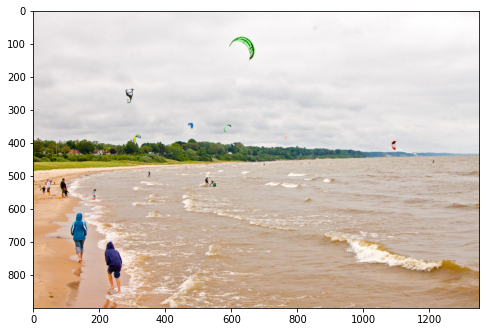

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

INPUT_SIZE = model.INPUT_SIZE

image_path = "./docs/kite.jpg"
image      = cv2.imread(image_path)
image      = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8,8))
plt.imshow(image)
plt.show()

# 탐지 실행

In [9]:
bboxes = model.predict(image)

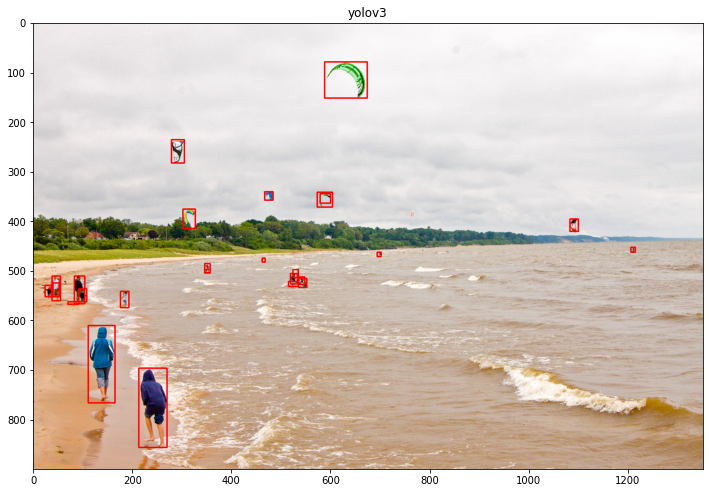

In [10]:
dummy = np.copy(image)

for box in bboxes:
    
    x1, y1, x2, y2 = int(box[0]), int(box[1]), int(box[2]), int(box[3])
    conf = box[4]
    cls_id = int(box[5])
        
    dummy = cv2.rectangle(dummy, (x1,y1), (x2,y2), (255,0,0), 2)
     
plt.figure(figsize=(12,10))
plt.gca().set_title("yolov3"), plt.imshow(dummy)
plt.show()

# 박스 그리기

In [11]:
import core
import colorsys
import random

def draw_bbox(image, bboxes, show_label=True):
    """
    bboxes: [x_min, y_min, x_max, y_max, probability, cls_id] format coordinates.
    """
    
    classes = core.utils.read_class_names("./data/classes/coco.names")

    num_classes = len(classes)
    image_h, image_w, _ = image.shape
    hsv_tuples = [(1.0 * x / num_classes, 1., 1.) for x in range(num_classes)]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colors))

    random.seed(0)
    random.shuffle(colors)
    random.seed(None)

    for i, bbox in enumerate(bboxes):
        coor = np.array(bbox[:4], dtype=np.int32)
        fontScale = 0.5
        score = bbox[4]
        class_ind = int(bbox[5])
        bbox_color = colors[class_ind]
        bbox_thick = int(0.6 * (image_h + image_w) / 600)
        c1, c2 = (coor[0], coor[1]), (coor[2], coor[3])
        cv2.rectangle(image, c1, c2, bbox_color, bbox_thick)

        if show_label:
            bbox_mess = '%s: %.2f' % (classes[class_ind], score)
            t_size = cv2.getTextSize(bbox_mess, 0, fontScale, thickness=bbox_thick//2)[0]
            cv2.rectangle(image, c1, (c1[0] + t_size[0], c1[1] - t_size[1] - 3), bbox_color, -1)  # filled

            cv2.putText(image, bbox_mess, (c1[0], c1[1]-2), cv2.FONT_HERSHEY_SIMPLEX,
                        fontScale, (0, 0, 0), bbox_thick//2, lineType=cv2.LINE_AA)

    return image


In [12]:
image = draw_bbox(image, bboxes)

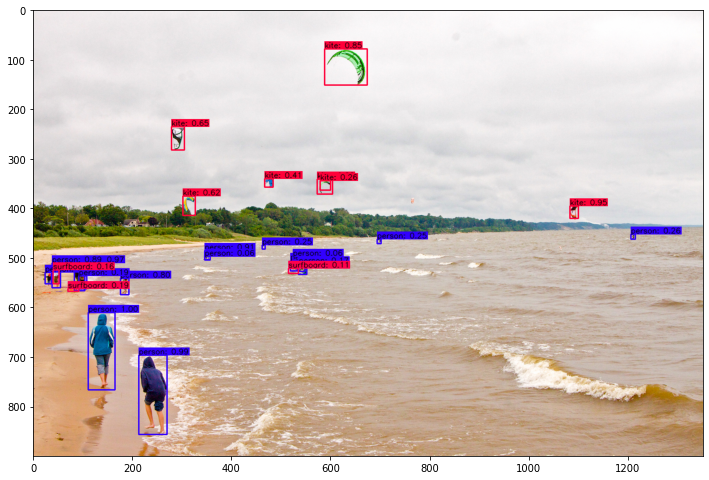

In [13]:
plt.figure(figsize=(12,10))
plt.imshow(image)
plt.show()

In [14]:
cv2.imwrite("detections_yolov3.jpg", cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

True